In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

#  Exploratory Data Analysis

### [1]. Reading Data

In [148]:
df = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/product_ratings/train_set_label.csv')
print(df.shape)
print('No. of data points in our data set: ', df.shape[0])
print('No. of features in our data set: ', df.shape[1])
df.head()

(7486, 17)
No. of data points in our data set:  7486
No. of features in our data set:  17


,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,average_review_rating
0,7f890f73298badd692c39c3801ef1d28,Batman - Role Play - Cowl and Batarang,Mattel,£14.99,NaN,4,1.0,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,"When kids aspire to be like Batman, it's easy ...",Technical Details Item Weight113 g Product Dim...,"When kids aspire to be like Batman, it's easy ...",http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,NaN,Item was broken // 3.0 // 2 April 2014 // By\n...,"{""seller""=>{""Seller_name_1""=>""a1 Toys"", ""Selle...",4.5
1,83e55a2edb6c13dfc1c46d1577321b2e,Doctor Who 12-inch 50th Anniversary Collector ...,Dr Who,NaN,3 new,73,NaN,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Doctor-Who-Classic-Dal...,Product Description This ultimate Doctor Who c...,Technical Details Item Weight1.4 Kg Product Di...,Product Description This ultimate Doctor Who c...,http://www.amazon.co.uk/Dr-Who-Dalek-Projectio...,NaN,A wonderful collectors piece // 5.0 // 31 Aug....,NaN,4.6
2,4bfaaf6558582a0f337ad59fcd51fcf7,Melissa & Doug Sticker Collection - Pink,Melissa & Doug,£4.76,15 new,47,1.0,Arts & Crafts > Paper & Stickers,http://www.amazon.co.uk/Melissa-Doug-Sticker-C...,"Product Description Cute couture, adorable ani...",Technical Details Item Weight299 g Product Dim...,"Product Description Cute couture, adorable ani...",http://www.amazon.co.uk/Melissa-Doug-Habitats-...,NaN,Great sticker collection // 5.0 // 19 Jun. 201...,NaN,4.7
3,4e6702cb7fe9278f16dedc39a8808c72,"Rock and Roll Cards, 30 Team",ClubKing Ltd,£4.49,2 new,2,1.0,Hobbies > Trading Cards & Accessories > Packs ...,http://www.amazon.co.uk/ClubKing-Ltd-Football-...,"1 Pack of 25 Football Cards, 30 rockstars on e...",Technical Details Item Weight100 g Product Dim...,"1 Pack of 25 Football Cards, 30 rockstars on e...",http://www.amazon.co.uk/ClubKing-Ltd-Football-...,how many cards in a pack it dosn't say..?? // ...,Rock and roll cards // 5.0 // 28 July 2013 // ...,"{""seller""=>[{""Seller_name_1""=>""ClubKing Ltd"", ...",5.0
4,f505611d18b0ae98258896ae1b0f14c8,Crayola 16 Pipsqueak Glitter Glues,Crayola,£5.99,9 new,10,1.0,Characters & Brands > Crayola,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,Product Description 16 Pipsqueak washable glit...,Technical Details Item Weight186 g Product Dim...,Product Description 16 Pipsqueak washable glit...,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,NaN,Little fingers big imagination // 5.0 // 4 Mar...,"{""seller""=>[{""Seller_name_1""=>""BIC WAREHOUSE"",...",4.2


In [149]:
#let's check data types of different features
df.dtypes

uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                               object
number_of_answered_questions                   float64
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
average_review_rating                          float64
dtype: object

In [104]:
#let's check the number of null values
df.isna().sum()

uniq_id                                           0
product_name                                      0
manufacturer                                      5
price                                          1069
number_available_in_stock                      1899
number_of_reviews                                 0
number_of_answered_questions                    577
amazon_category_and_sub_category                486
customers_who_bought_this_item_also_bought      821
description                                     473
product_information                              45
product_description                             473
items_customers_buy_after_viewing_this_item    2307
customer_questions_and_answers                 6817
customer_reviews                                  3
sellers                                        2314
average_review_rating                             0
dtype: int64

1.  We have total of 7486 data points in our data set, which is not much  given our problem is a NLP task as after vectorization and feture engineering, total no. of features will increase dramatically. This can cause `Overfitting` and we have to avoid overfitting in any case. Because of this reason we are mainly going to focus on some most important features like `customer_reviews` as customer review directly gives the essence of rating on the product. <br>

2. Although a lot of information can be recovered from most of the features present, since that will increase the no. of dimensions and causing `curse of dimensionality` .We are going to keep ourself close to most important features for now.<br>

3. In Machine learning more data the better it is we say, but certain data can confuse our model, Since `uniq_id` is different for every product so  this might confuse our model. There fore we are going to drop this column.<br>

4. There are lot of missing values in our data set.<br>

5. There are total unique 7466 `product_name`in our data set. This means most of data has unique products.

6. `description` and `product_description` looks same and has same number of missing values as well,therefore we can drop one out of them.




  

Oxford Diecast             126
LEGO                       119
Disney                     118
Playmobil                   95
Mattel                      93
                          ... 
Cardinal                     1
Magical Minerals             1
Matfield Lavender Gifts      1
Delph Miniatures             1
Rockyoo                      1
Name: manufacturer, Length: 2254, dtype: int64


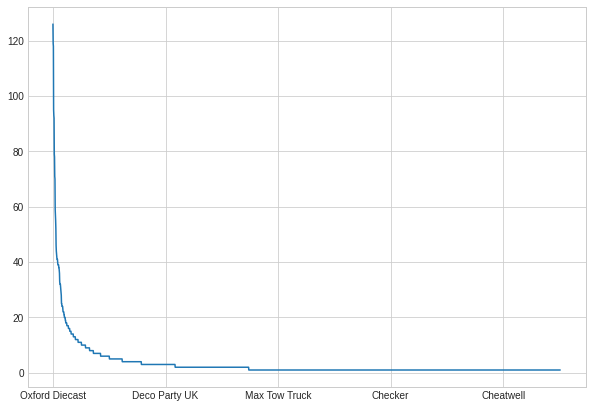

In [107]:
print(df['manufacturer'].value_counts())
df['manufacturer'].value_counts().plot(figsize =(10,7))

## [2] Data Cleaning: Deduplication

Let's check for duplicated data.If the data had many duplicate entries, it is necessary to remove duplicates in order to get unbiased results for the analysis of the data.<br>

The method we are going to use is that we first sort the data according to `unique_id` and then just keep the first similar product review and delete the others.This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

Also we will count the number of `uniq_id` and `product_name` and if these number are equal to the data points i.e. `7486`, this would further help in deciding if there is no Duplicate values in our data set.<br>



In [150]:
#Sorting data according to uniq_id in ascending order
sorted_data = df.sort_values('uniq_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [151]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"uniq_id","product_name","customer_reviews"}, keep='first', inplace=False)
final.shape

(7486, 17)

In [152]:
print('The number of unique id in our data set: ',final['uniq_id'].value_counts().sum())
print('The number of unique product name in our data set: ',final['product_name'].value_counts().sum())

The number of unique id in our data set:  7486
The number of unique product name in our data set:  7486


**It seems like we don't have duplicated values in our dataset**

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

**Since Customer reviews is directly related to the avg rating given by the customers (through experience and observation), we are going to target csutomer reviews for buliding our NLP model.**

Though we should de preprocessing and featurization of all the data, as of now we are focussing on `customer reviews`. 

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>


In [153]:
# printing some random reviews
sent_0 = final['customer_reviews'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['customer_reviews'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['customer_reviews'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['customer_reviews'].values[4900]
print(sent_4900)
print("="*50)

Good figure // 5.0 // 30 Jan. 2014 // By
    
    Xray and vav
  
 on 30 Jan. 2014 // This is a good figure. It's well painted and well articulated. If you liked the character and the game from resident evil 6 then I highly recommend it.
Five Stars // 5.0 // 14 Oct. 2014 // By
    
    Piotr Bawor
  
 on 14 Oct. 2014 // A good buy. Thanks
My third Flexifoil and it's excellent // 5.0 // 20 Jan. 2015 // By
    
    Avid Reader
  
 on 20 Jan. 2015 // Got this beauty last week ready for a trip to the coast this weekend - its my 3rd Flexifoil and they are as excellent as ever.  Good to get this when it was reduced.  I think that this is the biggest Sting so its quite a workout but easy and great fun to fly. It's certainly the biggest one I've got.  If you don't know Flexifoil kites are aerofoil kites - so no spars or struts to break as it's a wing shape and is aerodynamically designed.  The whole thing folds or squashes up into the accompanying rucksack.  Easy to get going and easy to put a

So we have text, date, rating and the person who is rating.<br>

we need to:

1. Keep the text.
2. We will be removing slashes(//).
3. We will be removing rating as well, since we have avg rating column.
4. Date of reviews are given, for now we are going to remove that as well. But it can help to build a powerful model.

In [154]:
# remove urls from text if any python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Good figure // 5.0 // 30 Jan. 2014 // By
    
    Xray and vav
  
 on 30 Jan. 2014 // This is a good figure. It's well painted and well articulated. If you liked the character and the game from resident evil 6 then I highly recommend it.


In [155]:
len(np.unique(final['average_review_rating']))

17

In [156]:
# removing html tags if any
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Good figure // 5.0 // 30 Jan. 2014 // By
    
    Xray and vav
  
 on 30 Jan. 2014 // This is a good figure. It's well painted and well articulated. If you liked the character and the game from resident evil 6 then I highly recommend it.
Five Stars // 5.0 // 14 Oct. 2014 // By
    
    Piotr Bawor
  
 on 14 Oct. 2014 // A good buy. Thanks
My third Flexifoil and it's excellent // 5.0 // 20 Jan. 2015 // By
    
    Avid Reader
  
 on 20 Jan. 2015 // Got this beauty last week ready for a trip to the coast this weekend - its my 3rd Flexifoil and they are as excellent as ever.  Good to get this when it was reduced.  I think that this is the biggest Sting so its quite a workout but easy and great fun to fly. It's certainly the biggest one I've got.  If you don't know Flexifoil kites are aerofoil kites - so no spars or struts to break as it's a wing shape and is aerodynamically designed.  The whole thing folds or squashes up into the accompanying rucksack.  Easy to get going and easy to put a

In [157]:

# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [158]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My third Flexifoil and it is excellent // 5.0 // 20 Jan. 2015 // By
    
    Avid Reader
  
 on 20 Jan. 2015 // Got this beauty last week ready for a trip to the coast this weekend - its my 3rd Flexifoil and they are as excellent as ever.  Good to get this when it was reduced.  I think that this is the biggest Sting so its quite a workout but easy and great fun to fly. It is certainly the biggest one I have got.  If you do not know Flexifoil kites are aerofoil kites - so no spars or struts to break as it is a wing shape and is aerodynamically designed.  The whole thing folds or squashes up into the accompanying rucksack.  Easy to get going and easy to put away and I had mine sorted was flying it within a few minutes.  Its a four line kite so you fly it via handles with two strings per handle (top and bottom).  Means you can do multiple loop the loops and 'fly' the kite across the sky really easily.  Also you can 'collapse' the aerofoil by moving the handles forward (or in fact just let

In [159]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Good figure //  //  Jan.  // By
    
    Xray and vav
  
 on  Jan.  // This is a good figure. It's well painted and well articulated. If you liked the character and the game from resident evil  then I highly recommend it.


In [160]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
sent_0 =  re.sub('[^A-Za-z0-9]+', ' ', sent_0)
print(sent_1500)
print('-'*50)
print(sent_0)

My third Flexifoil and it is excellent 5 0 20 Jan 2015 By Avid Reader on 20 Jan 2015 Got this beauty last week ready for a trip to the coast this weekend its my 3rd Flexifoil and they are as excellent as ever Good to get this when it was reduced I think that this is the biggest Sting so its quite a workout but easy and great fun to fly It is certainly the biggest one I have got If you do not know Flexifoil kites are aerofoil kites so no spars or struts to break as it is a wing shape and is aerodynamically designed The whole thing folds or squashes up into the accompanying rucksack Easy to get going and easy to put away and I had mine sorted was flying it within a few minutes Its a four line kite so you fly it via handles with two strings per handle top and bottom Means you can do multiple loop the loops and fly the kite across the sky really easily Also you can collapse the aerofoil by moving the handles forward or in fact just letting go and the kite just crumples and floats back to e

In [161]:
def removing_months(phrase):
  
  phrase = re.sub(r"Jan", "", phrase)
  phrase = re.sub(r"Mar", "", phrase)
  phrase = re.sub(r"Apr", "", phrase)
  phrase = re.sub(r"May", "", phrase)
  phrase = re.sub(r"Jun", "", phrase)
  phrase = re.sub(r"July", "", phrase)  
  phrase = re.sub(r"Aug", "", phrase)
  phrase = re.sub(r"Sept", "", phrase)
  phrase = re.sub(r"Oct", "", phrase)
  phrase = re.sub(r"Nov", "", phrase)
  phrase = re.sub(r"Dec", "", phrase)
  
  return phrase

In [162]:
sent_1500 = removing_months(sent_1500)
print(sent_1500)

My third Flexifoil and it is excellent 5 0 20  2015 By Avid Reader on 20  2015 Got this beauty last week ready for a trip to the coast this weekend its my 3rd Flexifoil and they are as excellent as ever Good to get this when it was reduced I think that this is the biggest Sting so its quite a workout but easy and great fun to fly It is certainly the biggest one I have got If you do not know Flexifoil kites are aerofoil kites so no spars or struts to break as it is a wing shape and is aerodynamically designed The whole thing folds or squashes up into the accompanying rucksack Easy to get going and easy to put away and I had mine sorted was flying it within a few minutes Its a four line kite so you fly it via handles with two strings per handle top and bottom Means you can do multiple loop the loops and fly the kite across the sky really easily Also you can collapse the aerofoil by moving the handles forward or in fact just letting go and the kite just crumples and floats back to earth W

In [163]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [164]:
final.dtypes

uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                               object
number_of_answered_questions                   float64
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
average_review_rating                          float64
dtype: object

In [165]:
# Combining all the above stundents 

#changing object dtype to string
final['customer_reviews'] = final['customer_reviews'].astype('str') 

from tqdm import tqdm

preprocessed_reviews = []

# tqdm is for printing the status bar
for sentance in tqdm(final['customer_reviews'].values):
    
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = removing_months(sentance)

    #changing to lower case and removing stop words 
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 7486/7486 [00:02<00:00, 2679.03it/s]


### Similarly, preprocessing can be done to other features as well. 

In [166]:
#let's check pre-processed review of one of the product
preprocessed_reviews[1500]

'third flexifoil excellent avid reader got beauty last week ready trip coast weekend flexifoil excellent ever good get reduced think biggest sting quite workout easy great fun fly certainly biggest one got not know flexifoil kites aerofoil kites no spars struts break wing shape aerodynamically designed whole thing folds squashes accompanying rucksack easy get going easy put away mine sorted flying within minutes four line kite fly via handles two strings per handle top bottom means multiple loop loops fly kite across sky really easily also collapse aerofoil moving handles forward fact letting go kite crumples floats back earth little practice also land upright ready fly tug handles daughters love great see one reduced high standard whole happy kite way flies foogy previously purchased flexifoil kites past expected high standard whole happy kite way flies bit disappointed cheap feel aluminium handles flexifoil kites really solid plastic handles super grippy rubber kinda feel aluminium o

> Before we start to featurize our data, that is converting data into vectors, we have to split our data into train and test data, in order to avoid the problem of data leakage.

We will be spillting our data as : <br>
1. 80% Training data <br>
2. 20% Testing data <br>

In [167]:
final['customer_reviews'] = preprocessed_reviews
final.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,average_review_rating
3889,0016eb63fa6c7a5e8930bc7732b13116,Resident Evil 6 Play Arts Kai Helena Harper Ac...,Unknown,£49.88,12 new,1,1.0,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Resident-Evil-Kennedy-...,Product Description From Square Enix! From the...,Technical Details Item Weight454 g Product Dim...,Product Description From Square Enix! From the...,http://www.amazon.co.uk/Resident-Evil-Revelati...,NaN,good figure xray vav good figure well painted ...,"{""seller""=>[{""Seller_name_1""=>""Star Action Fig...",5.0
187,00182f9b6081e58fea1fe76bc13eb022,Disney Frozen Musical and Light-Up Elsa Fancy ...,George,£24.99,3 new,3,1.0,Characters & Brands > Disney > Toys,http://www.amazon.co.uk/Disney-Frozen-Elsas-Mu...,"LET IT go, let it go, cant hold it back any mo...",Technical Details Item Weight399 g Product Dim...,"LET IT go, let it go, cant hold it back any mo...",NaN,NaN,five stars sandra siert granddaughter loved dr...,"{""seller""=>[{""Seller_name_1""=>""Cindy's Little ...",4.3
5120,0030f5965cbd07a138147425b9a0156c,Disney The Lion King Childrens 24 Piece Simba ...,King International,£6.53,3 new,1,1.0,Characters & Brands > Disney > Toys,http://www.amazon.co.uk/Ravensburger | http://...,NaN,Technical Details Manufacturer recommended age...,NaN,http://www.amazon.co.uk/Disney-King-4-In-1-Puz...,NaN,five stars charles parker good,"{""seller""=>[{""Seller_name_1""=>""Quickdraw Stati...",5.0
484,0034d77b68130bba71aca6e733c7e1ac,Pokemon Black and White Voice Activated Talkin...,Takara Tomy,£30.23,3 new,1,1.0,Characters & Brands > Tomy,http://www.amazon.co.uk/Pokemon-Oshawott-Plush...,Pokemon Black and White Voice Activated Talkin...,Technical Details Manufacturer recommended age...,Pokemon Black and White Voice Activated Talkin...,NaN,NaN,great louise great toy love talks sounds thank...,"{""seller""=>[{""Seller_name_1""=>""Buy-For-Less-On...",5.0
1863,0039295c7fcefba10d5fc333eff806d3,LEGO City Airport 60022: Cargo Terminal,LEGO,£199.18,16 new,105,1.0,NaN,http://www.amazon.co.uk/LEGO-City-Airport-6002...,Product Description Get busy loading the cargo...,Technical Details Item Weight1.8 Kg Product Di...,Product Description Get busy loading the cargo...,http://www.amazon.co.uk/LEGO-60095-Explorers-E...,NaN,lego city cargo terminal set largest recent le...,"{""seller""=>[{""Seller_name_1""=>""BrickVault"", ""S...",4.7


### Splitting our data before converting into to vectors to avoid data leakage. 

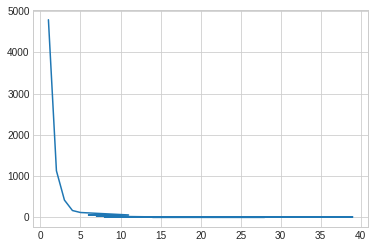

In [168]:
df.number_of_answered_questions.value_counts().plot()

In [169]:
final.isna().sum()

uniq_id                                           0
product_name                                      0
manufacturer                                      5
price                                          1069
number_available_in_stock                      1899
number_of_reviews                                 0
number_of_answered_questions                    577
amazon_category_and_sub_category                486
customers_who_bought_this_item_also_bought      821
description                                     473
product_information                              45
product_description                             473
items_customers_buy_after_viewing_this_item    2307
customer_questions_and_answers                 6817
customer_reviews                                  0
sellers                                        2314
average_review_rating                             0
dtype: int64

In [170]:
final.dtypes

uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                               object
number_of_answered_questions                   float64
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
average_review_rating                          float64
dtype: object

In [171]:
print(final['manufacturer'].value_counts())
final['manufacturer'] = final['manufacturer'].astype('category').cat.as_ordered()
print(len(list(set(final['manufacturer'].cat.codes))))

Oxford Diecast                            126
LEGO                                      119
Disney                                    118
Playmobil                                  95
Mattel                                     93
                                         ... 
Believe You Can                             1
Linkee 4 little questions. 1 big link.      1
Icon                                        1
MASSEY FERGUSON Tronico                     1
Rockyoo                                     1
Name: manufacturer, Length: 2254, dtype: int64
2255


In [172]:
print(len(list(set(final['manufacturer'].cat.codes))))
print(final.shape)

2255
(7486, 17)


Although manufacturer is a strong feature deciding in customer rating, since we have 2255 unique manufacturers and only 7486 data points, this may again lead to overfitting as well and it will increase the dimensionality when converted to numerical data.

*So, we have to drop the manufacturer column as well*


In [173]:
#converting to float and filling missing values with median
final['number_of_answered_questions'] = final['number_of_answered_questions'].astype(float)
final['number_of_answered_questions'] = final['number_of_answered_questions'].fillna(final['number_of_answered_questions'].median())


final['manufacturer'] = final['manufacturer'].astype('category').cat.as_ordered()

no_of_reviews = list()

for review_count in tqdm(final['number_of_reviews'].values):
  review_count = re.sub(",","",review_count)
  no_of_reviews.append(review_count)

final['number_of_reviews'] = no_of_reviews
final['number_of_reviews']= final['number_of_reviews'].astype(float)

product_category = list()       #list for storing processed category types
product_subcategory = list()

for types in df['amazon_category_and_sub_category'].values:
  
  types = str(types)
  types = re.sub("\S*\d\S*", "", types).strip()                   #removing numbers
  types = re.sub('[^A-Za-z]+', ' ', types)                        #removing special characters
  
  product_category.append(types.split()[0])
  product_subcategory.append(types.split()[-1])                #just keeping the category and ignoring sub categories

print('The no. of unique categories : ',len(list(set(product_category))))
print('The no. of unique sub categories : ',len(list(set(product_subcategory))))


final['product_category'] = product_category
final['product_subcategory'] = product_subcategory

final['product_category'] = final['product_category'].astype('category').cat.as_ordered()
final['product_subcategory'] = final['product_subcategory'].astype('category').cat.as_ordered()


label_encoder_manufac = LabelEncoder()

final['manufacturer'] = final['manufacturer'].astype('category').cat.as_ordered()
final['manufacturer'] = final['manufacturer'].fillna(final['manufacturer'].value_counts().index[0])
final['manufacturer'] = label_encoder_manufac.fit_transform(final['manufacturer'])


label_encoder_cat = LabelEncoder()
final['product_category'] = label_encoder_cat.fit_transform(final['product_category'])

label_encoder_subcat = LabelEncoder()
final['product_subcategory'] = label_encoder_subcat.fit_transform(final['product_subcategory'])

#dropping features
final = final.drop('uniq_id', axis = 1)
final = final.drop('price', axis = 1)
final = final.drop('product_name', axis = 1)
final = final.drop('customer_questions_and_answers', axis = 1)
final = final.drop('items_customers_buy_after_viewing_this_item', axis = 1)
final = final.drop('sellers', axis = 1)
final = final.drop('description', axis = 1)
final = final.drop('product_description', axis = 1)
final = final.drop('number_available_in_stock', axis = 1)  
final = final.drop('customers_who_bought_this_item_also_bought', axis = 1)
final = final.drop('amazon_category_and_sub_category', axis = 1)
final = final.drop('product_information', axis = 1)



100%|██████████| 7486/7486 [00:00<00:00, 830913.51it/s]

The no. of unique categories :  40
The no. of unique sub categories :  157


In [174]:
print(final.dtypes)
print('-'*50)
print(final.shape)
print('-'*50)
print(final.isna().sum())

manufacturer                      int64
number_of_reviews               float64
number_of_answered_questions    float64
customer_reviews                 object
average_review_rating           float64
product_category                  int64
product_subcategory               int64
dtype: object
--------------------------------------------------
(7486, 7)
--------------------------------------------------
manufacturer                    0
number_of_reviews               0
number_of_answered_questions    0
customer_reviews                0
average_review_rating           0
product_category                0
product_subcategory             0
dtype: int64


In [175]:
X = final.drop('average_review_rating', axis = 1)
y = final['average_review_rating']

#let's split our data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (5988, 6)
Shape of y_train:  (5988,)
Shape of X_test:  (1498, 6)
Shape of y_test:  (1498,)


In [59]:
df_1_train = X_train.drop('customer_reviews', axis = 1)

df_1_train = df_1_train.reset_index()
print(df_1_train.shape)
df_1_train.head()

(5988, 6)


,index,manufacturer,number_of_reviews,number_of_answered_questions,product_category,product_subcategory
0,2826,588,1.0,1.0,14,53
1,4857,479,1.0,2.0,13,48
2,3209,1716,12.0,1.0,29,8
3,1319,507,3.0,1.0,12,69
4,502,203,1.0,1.0,17,20


In [60]:
df_1_test = X_test.drop('customer_reviews', axis = 1)

df_1_test = df_1_test.reset_index()
print(df_1_test.dtypes)
df_1_test.head()

index                             int64
manufacturer                      int64
number_of_reviews               float64
number_of_answered_questions    float64
product_category                  int64
product_subcategory               int64
dtype: object


,index,manufacturer,number_of_reviews,number_of_answered_questions,product_category,product_subcategory
0,2354,1278,1.0,1.0,14,53
1,3021,19,1.0,1.0,29,8
2,2204,1550,1.0,1.0,14,27
3,4217,1489,3.0,4.0,7,149
4,5457,1184,1.0,2.0,0,123


In [61]:
print(df_1_test.shape)
df_1_test.isna().sum()

(1498, 6)


index                           0
manufacturer                    0
number_of_reviews               0
number_of_answered_questions    0
product_category                0
product_subcategory             0
dtype: int64

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

# [4] Featurization

1. Bag of Words(BOW)<br>
2. TF-IDF<br>
3. Word2Vec<br>
4. TFIDF-Word2Vec<br>
5. AvgW2V

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=1000) 
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

#tranforming our training data
X_train_bow_counts = count_vect.transform(X_train)

#transforming test data
X_test_bow_counts  = count_vect.transform(X_test)   #not fitting on test data to avoid data leakage

print("the type of count vectorizer ",type(X_train_bow_counts))
print("the shape of out X_train text BOW vectorizer ",X_train_bow_counts.get_shape())
print("the number of unique words ", X_train_bow_counts.get_shape()[1])
print("the shape of out X_test text BOW vectorizer ",X_test_bow_counts.get_shape())


some feature names  ['able', 'absolutely', 'accessories', 'accurate', 'across', 'action', 'actual', 'actually', 'add', 'added']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out X_train text BOW vectorizer  (5988, 1000)
the number of unique words  1000
the shape of out X_test text BOW vectorizer  (1498, 1000)


## [4.2] Bi-Grams

In [ ]:
#initializing bi-grams
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=1000)

#fitting and tranforming our training data
X_train_bigram_counts = count_vect.fit_transform(X_train)

#transforming our test data
X_test_bigram_counts = count_vect.fit_transform(X_test)



print("the type of count vectorizer ",type(X_train_bigram_counts))

print("the number of unique words including both unigrams and bigrams ", X_train_bigram_counts.get_shape()[1])
print("the shape of out X_train BOW vectorizer ",X_train_bigram_counts.get_shape())

print("the shape of out X_test BOW vectorizer ",X_test_bigram_counts.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  1000
the shape of out X_train BOW vectorizer  (5988, 1000)
the shape of out X_test BOW vectorizer  (1498, 1000)


## [4.3] TF-IDF

In [62]:
#initializing TFIDF vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 1000)

#fitting TFIDF vectorizer on our training data
tf_idf_vect.fit(X_train['customer_reviews'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

#transforming our train and test data
X_train_tf_idf = tf_idf_vect.transform(X_train['customer_reviews'])
X_test_tf_idf = tf_idf_vect.transform(X_test['customer_reviews'])

print("the type of count vectorizer ",type(X_train_tf_idf))
print("the number of unique words including both unigrams and bigrams ", X_train_tf_idf.get_shape()[1])

print("the shape of out X_train TFIDF vectorizer ",X_train_tf_idf.get_shape())
print("the shape of out X_test TFIDF vectorizer ",X_test_tf_idf.get_shape())

some sample features(unique words in the corpus) ['able', 'absolutely', 'absolutely loves', 'accessories', 'accurate', 'across', 'action', 'actual', 'actually', 'add']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  1000
the shape of out X_train TFIDF vectorizer  (5988, 1000)
the shape of out X_test TFIDF vectorizer  (1498, 1000)


In [63]:
X_train_tf_idf = X_train_tf_idf.toarray()
df_X_train_tfidf = pd.DataFrame(X_train_tf_idf)
df_X_train_tfidf = df_X_train_tfidf.reset_index()


X_test_tf_idf = X_test_tf_idf.toarray()
df_X_test_tfidf = pd.DataFrame(X_test_tf_idf)
df_X_test_tfidf = df_X_test_tfidf.reset_index()

full_train_tfidf = pd.concat([df_X_train_tfidf, df_1_train], axis=1)
full_test_tfidf = pd.concat([df_X_test_tfidf, df_1_test], axis=1)

In [64]:
print(full_train_tfidf.shape)
print(full_test_tfidf.shape)

full_test_tfidf.head()

(5988, 1007)
(1498, 1007)


,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,index,manufacturer,number_of_reviews,number_of_answered_questions,product_category,product_subcategory
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2354,1278,1.0,1.0,14,53
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3021,19,1.0,1.0,29,8
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2204,1550,1.0,1.0,14,27
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223795,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4217,1489,3.0,4.0,7,149
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5457,1184,1.0,2.0,0,123


In [65]:
print(full_train_tfidf.dtypes)
print("-"*20)
print(full_test_tfidf.dtypes)

index                             int64
0                               float64
1                               float64
2                               float64
3                               float64
                                 ...   
manufacturer                      int64
number_of_reviews               float64
number_of_answered_questions    float64
product_category                  int64
product_subcategory               int64
Length: 1007, dtype: object
--------------------
index                             int64
0                               float64
1                               float64
2                               float64
3                               float64
                                 ...   
manufacturer                      int64
number_of_reviews               float64
number_of_answered_questions    float64
product_category                  int64
product_subcategory               int64
Length: 1007, dtype: object


## [4.4] Word2Vec


In [ ]:
# Training our own Word2Vec model using your own X_train text corpus

i=0
X_train_list_of_sentance=[]

for sentance in X_train:
    X_train_list_of_sentance.append(sentance.split())

print('Total no. of reviews in X_train_list_of_sentance,:', len(X_train_list_of_sentance))

print('Fitting W2V model on training data')
print('Fitting', '-'*50)
w2v_model=Word2Vec(X_train_list_of_sentance, min_count=5, size=20, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

Total no. of reviews in X_train_list_of_sentance,: 5988
Fitting W2V model on training data
Fitting --------------------------------------------------
[('fantastic', 0.9378909468650818), ('brilliant', 0.9221017956733704), ('good', 0.8855198621749878), ('excellent', 0.8850812911987305), ('amazing', 0.8756124973297119), ('exellent', 0.8535178899765015), ('fab', 0.8276509046554565), ('fabulous', 0.8151669502258301), ('ds', 0.8067746758460999), ('nicol', 0.7808699011802673)]
[('factory', 0.9907703995704651), ('notice', 0.9886043071746826), ('figurines', 0.9866409301757812), ('picking', 0.9863051772117615), ('secret', 0.9859878420829773), ('seek', 0.9859193563461304), ('improvement', 0.985916256904602), ('hitting', 0.9856383800506592), ('flame', 0.9856007099151611), ('admit', 0.9854202270507812)]


In [ ]:
i=0
X_test_list_of_sentance=[]

for sentance in X_test:
    X_test_list_of_sentance.append(sentance.split())

print('Total no. of reviews in X_train_list_of_sentance,:', len(X_test_list_of_sentance))

Total no. of reviews in X_train_list_of_sentance,: 1498


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6814
sample words  ['lovely', 'old', 'scenery', 'j', 'bought', 'present', 'friend', 'never', 'really', 'enjoyed', 'jigsaws', 'child', 'scene', 'similar', 'place', 'would', 'summer', 'quality', 'good', 'five', 'stars', 'great', 'family', 'game', 'style', 'uno', 'challenging', 'rules', 'move', 'onto', 'kids', 'older', 'need', 'challenge', 'brilliant', 'feb', 'fantastic', 'introduced', 'usa', 'dinner', 'fun', 'afternoon', 'lots', 'friends', 'members', 'excellent', 'card', 'k', 'dale', 'took']


In [185]:
# average Word2Vec
# compute average word2vec for each review on training data.

X_train_sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(X_train_list_of_sentance): # for each review/sentence
    
    X_train_sent_vec = np.zeros(10) # as word vectors are of zero length 50
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            
            vec = w2v_model.wv[word]
            X_train_sent_vec += vec
            cnt_words += 1
    
    if cnt_words != 0:
        X_train_sent_vec /= cnt_words
    X_train_sent_vectors.append(X_train_sent_vec)

print(len(X_train_sent_vectors))
print(len(X_train_sent_vectors[0]))

In [184]:
# average Word2Vec
# compute average word2vec for each review on testing data.

X_test_sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(X_test_list_of_sentance): # for each review/sentence
    
    X_test_sent_vec = np.zeros(10) # as word vectors are of zero length 50
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            
            vec = w2v_model.wv[word]
            X_test_sent_vec += vec
            cnt_words += 1
    
    if cnt_words != 0:
        X_test_sent_vec /= cnt_words
    X_test_sent_vectors.append(X_test_sent_vec)




#### [4.4.1.2] TFIDF weighted W2v

1. import and initialzie tfidf vectorizer. Then `fit` your data onto the model<br>
2. Make a dict with keys as words and values as idf values, we will calculate tf values later as we get our words from sentances.<br>
3. loop through sentances of `list_of_sentance`, since it contains words in a list format of sentances, so we can calculate term freuency(tf) values of every word as well as W2V vector for every word in a sentance.<br>
4. Afer getting tf and idf values, multiply those values together for word from dict and then multiply with W2V vector.<br>
5. divide by sum of tfidf value of every sentances at last, so while looping add every tfidf value for word.<br>


In [ ]:
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

for sent in tqdm(X_train_list_of_sentance): # for each review/sentence 
    
    X_train_sent_vec = np.zeros(10) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            
            vec = w2v_model.wv[word]

            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            X_train_sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    
    if weight_sum != 0:
        X_train_sent_vec /= weight_sum
    
    X_train_tfidf_sent_vectors.append(X_train_sent_vec)
    row += 1

100%|██████████| 5988/5988 [01:59<00:00, 49.95it/s]


In [ ]:
X_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

for sent in tqdm(X_test_list_of_sentance): # for each review/sentence 
    
    X_test_sent_vec = np.zeros(10) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            
            vec = w2v_model.wv[word]

            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            X_test_sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    
    if weight_sum != 0:
        X_test_sent_vec /= weight_sum
    
    X_test_tfidf_sent_vectors.append(X_test_sent_vec)
    row += 1

100%|██████████| 1498/1498 [00:30<00:00, 49.78it/s]


## [5]. Dimensionality Reduction and Data Visualization using TSNE.

1. TSNE on BOW
2. TSNE on TFIDF
3. TSNE on TFIDF-W2V
4. TSNE on Avg-W2V

TSNE is a dimensionality reduction technique (data visualization). For more details check out the following blog:

https://colah.github.io/posts/2014-10-Visualizing-MNIST/

Since we have to apply TSNE to all 4 type of vectors, let's make a function which does it for us.

In [ ]:
final.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,average_review_rating
3889,0016eb63fa6c7a5e8930bc7732b13116,Resident Evil 6 Play Arts Kai Helena Harper Ac...,Unknown,£49.88,12 new,1,1.0,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Resident-Evil-Kennedy-...,Product Description From Square Enix! From the...,Technical Details Item Weight454 g Product Dim...,Product Description From Square Enix! From the...,http://www.amazon.co.uk/Resident-Evil-Revelati...,NaN,good figure xray vav good figure well painted ...,"{""seller""=>[{""Seller_name_1""=>""Star Action Fig...",5.0
187,00182f9b6081e58fea1fe76bc13eb022,Disney Frozen Musical and Light-Up Elsa Fancy ...,George,£24.99,3 new,3,1.0,Characters & Brands > Disney > Toys,http://www.amazon.co.uk/Disney-Frozen-Elsas-Mu...,"LET IT go, let it go, cant hold it back any mo...",Technical Details Item Weight399 g Product Dim...,"LET IT go, let it go, cant hold it back any mo...",NaN,NaN,five stars sandra siert granddaughter loved dr...,"{""seller""=>[{""Seller_name_1""=>""Cindy's Little ...",4.3
5120,0030f5965cbd07a138147425b9a0156c,Disney The Lion King Childrens 24 Piece Simba ...,King International,£6.53,3 new,1,1.0,Characters & Brands > Disney > Toys,http://www.amazon.co.uk/Ravensburger | http://...,NaN,Technical Details Manufacturer recommended age...,NaN,http://www.amazon.co.uk/Disney-King-4-In-1-Puz...,NaN,five stars charles parker good,"{""seller""=>[{""Seller_name_1""=>""Quickdraw Stati...",5.0
484,0034d77b68130bba71aca6e733c7e1ac,Pokemon Black and White Voice Activated Talkin...,Takara Tomy,£30.23,3 new,1,1.0,Characters & Brands > Tomy,http://www.amazon.co.uk/Pokemon-Oshawott-Plush...,Pokemon Black and White Voice Activated Talkin...,Technical Details Manufacturer recommended age...,Pokemon Black and White Voice Activated Talkin...,NaN,NaN,great louise great toy love talks sounds thank...,"{""seller""=>[{""Seller_name_1""=>""Buy-For-Less-On...",5.0
1863,0039295c7fcefba10d5fc333eff806d3,LEGO City Airport 60022: Cargo Terminal,LEGO,£199.18,16 new,105,1.0,NaN,http://www.amazon.co.uk/LEGO-City-Airport-6002...,Product Description Get busy loading the cargo...,Technical Details Item Weight1.8 Kg Product Di...,Product Description Get busy loading the cargo...,http://www.amazon.co.uk/LEGO-60095-Explorers-E...,NaN,lego city cargo terminal set largest recent le...,"{""seller""=>[{""Seller_name_1""=>""BrickVault"", ""S...",4.7


In [ ]:
#standardizing our data_first
def standardized(data):
    return StandardScaler().fit_transform(data)

def tsne_plot(data,n = int,kind=None):
    '''
    plots TSNE plots for given data with different perplexity values and no. of iterations.
    data = pandas dataframe
    n = int,no. of iterations
    kind = None,(bow, tfidf, AvgwW2V, Tfidf-W2V) 
    n_vectors = no. of top eigen vectors you want . default = 2
    '''
  
    #initialzing our model for multiple perplexities
    for perp in range(15,51,10):
      tsne_model = TSNE(perplexity = perp, n_iter = n, random_state= 0)
      
      #fitting and transforming data
      tsne_data = tsne_model.fit_transform(data)
      
      #let's build a dataframe for plotting
      df = pd.DataFrame(tsne_data,columns=['1st_Principal','2nd_principal'])
      df['average_review_rating'] = final['average_review_rating']
      
      #plotting data
      plt.style.use('seaborn-whitegrid')

      #scatter plot
      sns.FacetGrid(df,hue='average_review_rating',size=7).map(plt.scatter,'1st_Principal','2nd_principal').add_legend()
      plt.title(f'TSNE plot of:{kind}')
      plt.show()


### [5.1] TSNE on BOW

In [ ]:
print('Type of bow_grams_final_count: ',type(final_bigram_counts))
print('Shape of grams_final_count: ',final_bigram_counts.shape)

Type of bow_grams_final_count:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of grams_final_count:  (7486, 5000)


> TSNE and BOW gives sparse matrices, we have to convert them to  dense arrays.

In [ ]:
final_bigram_counts = final_bigram_counts.toarray()

print('Type of final_bigram_counts: ',type(final_bigram_counts))

Type of final_bigram_counts:  <class 'numpy.ndarray'>


In [ ]:
#standardizing our data
standardized_data = standardized(final_bigram_counts)

#plotting TSNE
tsne_plot(data=standardized_data,n= 1000,kind = 'BOW')

### [5.2] TSNE on TFIDF

In [ ]:
print('Type of final_tf_idf: ',type(final_tf_idf))
print('Shape of final_tf_idf: ',final_tf_idf.shape)

In [ ]:
#let's make our sparse matrix dense
final_tf_idf = final_tf_idf.toarray()
print('Type of final_tf_idf: ',type(final_tf_idf))

In [ ]:
#standardizing our data
standardized_data = standardized(tfidf_final_count)

#ploting
tsne_plot(data=standardized_data,n= 1000,kind='TFidf')


### [5.3] TSNE on Avg-W2V 

In [ ]:
print(type(sent_vectors))
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [ ]:
#let's change our list of list to np array
avg_w2v_array = np.array(sent_vectors)

#standardising data
standardized_data = standardized(avg_w2v_array)

#plotting tsne
tsne_plot(data=standardized_data,n= 1000,kind='Avg W2V')


### [5.4] TSNE on TFIDF-W2V 

In [ ]:
print(len(tfidf_sent_vectors))
print(type(tfidf_sent_vectors))

In [ ]:
#converting list to array
tfidf_sent_vectors = np.array(tfidf_sent_vectors)

#Standardizing our array
standarized_data = standardized(tfidf_sent_vectors)

#plotting tsne
tsne_plot(data=standardized_data,n= 1000,kind='Tfidf W2V')


# [6] Data Modelling:

Prepraring data to fit into model

In [ ]:
#have to convert our sparse matrices back to dense arrays and then creating separate dataframes

#BOW
X_train_bow_counts = X_train_bow_counts.toarray()
df_X_train_bow_counts = pd.DataFrame(X_train_bow_counts)

#bi-grams BOW
X_train_bigram_counts = X_train_bigram_counts.toarray()
df_X_train_bigram_counts = pd.DataFrame(X_train_bigram_counts)

#tfidf
X_train_tf_idf = X_train_tf_idf.toarray()
df_X_train_tfidf = pd.DataFrame(X_train_tf_idf)

#https://datascience.stackexchange.com/questions/26333/convert-a-list-of-lists-into-a-pandas-dataframe

#avg-W2V
# df_X_train_avg_W2V = pd.DataFrame.from_records(X_train_sent_vectors)  #list of list to pandas data frame

# #tfidf-W2V
# df_X_train_tfidf_W2V = pd.DataFrame.from_records( X_train_tfidf_sent_vectors)



In [ ]:
print('Shape of df_X_train_bow_counts :',df_X_train_bow_counts.shape)
print('Shape of df_X_train_bigram_counts: ',df_X_train_bigram_counts.shape)
print('Shape of df_X_train_tfidf: ',df_X_train_tfidf.shape)
# print('Shape of df_X_train_avg_W2V: ',df_X_train_avg_W2V.shape)
# print('Shape of df_X_train_tfidf_W2V: ',df_X_train_tfidf_W2V.shape)

Shape of df_X_train_bow_counts : (5988, 1000)
Shape of df_X_train_bigram_counts:  (5988, 1000)
Shape of df_X_train_tfidf:  (5988, 1000)


In [ ]:
#have to convert our sparse matrices back to dense arrays and then creating separate dataframes

#BOW
X_test_bow_counts = X_test_bow_counts.toarray()
df_X_test_bow_counts = pd.DataFrame(X_test_bow_counts)

#bi-grams BOW
X_test_bigram_counts = X_test_bigram_counts.toarray()
df_X_test_bigram_counts = pd.DataFrame(X_test_bigram_counts)

#tfidf
X_test_tf_idf = X_test_tf_idf.toarray()
df_X_test_tfidf = pd.DataFrame(X_test_tf_idf)

#https://datascience.stackexchange.com/questions/26333/convert-a-list-of-lists-into-a-pandas-dataframe

#avg-W2V
# df_X_test_avg_W2V = pd.DataFrame.from_records(X_test_sent_vectors)  #list of list to pandas data frame

# #tfidf-W2V
# df_X_test_tfidf_W2V = pd.DataFrame.from_records( X_test_tfidf_sent_vectors)



In [ ]:
print('Shape of df_X_test_bow_counts :',df_X_test_bow_counts.shape)
print('Shape of df_X_test_bigram_counts: ',df_X_test_bigram_counts.shape)
print('Shape of df_X_test_tfidf: ',df_X_test_tfidf.shape)
print('Shape of df_X_test_avg_W2V: ',df_X_test_avg_W2V.shape)
print('Shape of df_X_test_tfidf_W2V: ',df_X_test_tfidf_W2V.shape)

Shape of df_X_test_bow_counts : (1498, 1000)
Shape of df_X_test_bigram_counts:  (1498, 1000)
Shape of df_X_test_tfidf:  (1498, 1000)
Shape of df_X_test_avg_W2V:  (1498, 10)
Shape of df_X_test_tfidf_W2V:  (1498, 10)


In [ ]:
print('Shape of y_train: ',y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of y_train:  (5988,)
Shape of y_test:  (1498,)


In [ ]:
training_data =  ['df_X_train_bow_counts','df_X_train_bigram_counts','df_X_train_tfidf','df_X_train_avg_W2V','df_X_train_tfidf_W2V']
testing_data  =  ['df_X_test_bow_counts' ,'df_X_test_bigram_counts', 'df_X_test_tfidf', 'df_X_test_avg_W2V', 'df_X_test_tfidf_W2V']

# [7] Regression Models

### [7.1] Linear Regression

In [ ]:
#find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


lr_reg=LinearRegression().fit(df_X_train_bow_counts , y_train)

y_pred = lr_reg.predict(df_X_test_bow_counts)
lr_test_predictions = [value for value in y_pred]
# y_pred = lr_reg.predict(df_train)
# lr_train_predictions = [round(value) for value in y_pred]

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,lr_test_predictions , squared = False)

0.36995578222853664

In [ ]:
 from sklearn.ensemble import RandomForestRegressor

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_X_train_bow_counts, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = regr1.predict(df_X_test_bow_counts)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.2979814870242669

In [67]:
full_train_tfidf.dtypes

index                             int64
0                               float64
1                               float64
2                               float64
3                               float64
                                 ...   
manufacturer                      int64
number_of_reviews               float64
number_of_answered_questions    float64
product_category                  int64
product_subcategory               int64
Length: 1007, dtype: object

In [68]:
from sklearn.ensemble import RandomForestRegressor

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(full_train_tfidf, y_train)

y_pred = regr1.predict(full_test_tfidf)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.29051209195211514

In [ ]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=3,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 reg_alpha=50, reg_lambda=10,
 colsample_bytree=0.8,nthread=4)

x_model.fit(df_X_train_bow_counts, y_train)

[12:17:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=2, missing=None, n_estimators=500,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=50, reg_lambda=10, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
y_pred = x_model.predict(df_X_test_bow_counts)
xgb_test_predictions = [value for value in y_pred]

mean_squared_error(y_test,xgb_test_predictions , squared = False)

0.3080676109123253

In [ ]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_X_train_bigram_counts, y_train)

y_pred = regr1.predict(df_X_test_bigram_counts)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.35526917706606026

In [ ]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_X_train_tfidf, y_train)

y_pred = regr1.predict(df_X_test_tfidf)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.29372226648076205

In [ ]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_X_train_avg_W2V, y_train)

y_pred = regr1.predict(df_X_test_avg_W2V)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.3431162050668049

In [ ]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_X_train_tfidf_W2V, y_train)

y_pred = regr1.predict(df_X_test_tfidf_W2V)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.350175791125601

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#grid for hyperparameters
rf_grid = {'n_estimators': np.arange(10,100,10),
          'max_depth':[None,3,5,10],
          'min_samples_split': np.arange(2,20,2),
          'min_samples_leaf':np.arange(1,20,2),
          'max_samples':[5988]}

# Instatiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                             n_iter=2,
                             cv=5,
                             verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train_tf_idf,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [ ]:
rs_model.best_params_

{'max_depth': None,
 'max_samples': 5988,
 'min_samples_leaf': 11,
 'min_samples_split': 6,
 'n_estimators': 70}

In [ ]:
y_pred = rs_model.predict(df_X_test_tfidf)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.29143699330392653

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                   param_grid = rf_grid,
                   cv=5,
                   verbose=True)

clf.fit(X_train_tf_idf,y_train)

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 16200 out of 16200 | elapsed:  5.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [ ]:
clf.best_params_

{'max_depth': None,
 'max_samples': 5988,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [ ]:
y_pred = clf.predict(df_X_test_tfidf)
test_predictions = [value for value in y_pred]

mean_squared_error(y_test,test_predictions , squared = False)

0.2992458874770595

# FINal

In [183]:
from sklearn.model_selection import RandomizedSearchCV

#grid for hyperparameters
rf_grid = {'n_estimators': np.arange(10,100,10),
          'max_depth':[None,3,5,10],
          'min_samples_split': np.arange(2,20,2),
          'min_samples_leaf':np.arange(1,20,2),
          'max_samples':[5988]}

# Instatiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                             n_iter=2,
                             cv=5,
                             verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X,y)

rs_model.best_params_

y_pred = rs_model.predict(df_X_test_tfidf)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished


{'max_depth': 3,
 'max_samples': 5988,
 'min_samples_leaf': 9,
 'min_samples_split': 14,
 'n_estimators': 50}

In [140]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/product_ratings/test_set_label.csv')

In [141]:
test_data.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,90093bd02c6d5ce6d6c8f2e2af411fc1,Dolls House Miniature Cats x2,Heidi Ott,£12.00,NaN,1,1.0,Dolls & Accessories > Dolls' House Dolls & Acc...,NaN,A pair of dolls house miniature cats. This 1/1...,Technical Details Item Weight5 g Product Dimen...,A pair of dolls house miniature cats. This 1/1...,NaN,NaN,Dolls house miniatures // 5.0 // 9 Jan. 2013 /...,"{""seller""=>{""Seller_name_1""=>""1 12 Dollshouses..."
1,8dec13104fd4d1ad3ad5d9ff2af9ca0b,Disney Princess T7561 Tangled Rapunzel's Gondo...,Disney Princess,NaN,5 new,15,4.0,Characters & Brands > Disney > Toys,http://www.amazon.co.uk/Disney-Princess-Y0942-...,Product Description Relive the romantic moment...,Technical Details Item Weight907 g Product Dim...,Product Description Relive the romantic moment...,http://www.amazon.co.uk/Disney-Princess-Y0942-...,NaN,Tangled // 4.0 // 16 May 2011 // By\n \n ...,"{""seller""=>[{""Seller_name_1""=>""Anita Mall"", ""S..."
2,0fcde78856668c1563f54650b17620e7,My Pirate Party Music CD,Unknown,£4.99,1 used,6,1.0,Figures & Playsets > Pirates,http://www.amazon.co.uk/Pirate-Pencils-Childre...,Set the atmosphere for your Pirate themed part...,Technical Details Manufacturer recommended age...,Set the atmosphere for your Pirate themed part...,http://www.amazon.co.uk/Jake-And-The-Neverland...,NaN,Okay but that's all // 1.0 // 11 July 2011 // ...,"{""seller""=>{""Seller_name_1""=>""BuzzBase"", ""Sell..."
3,69a9becbd60381a4eb7cdafe30761ee4,1ST BIRTHDAY BANNER GIRL (BGC HOLOGRAPHIC) 9FT...,Every-occasion-party-supplies,£1.49,5 new,22,1.0,"Party Supplies > Banners, Stickers & Confetti ...",http://www.amazon.co.uk/1ST-BIRTHDAY-GIRL-PINK...,12ft long,Technical Details Manufacturer recommended age...,12ft long,http://www.amazon.co.uk/12ft-Foil-Ladybird-Bir...,NaN,Good quality but take down carefully as the fo...,NaN
4,18bc8b988f43f352b946a253642e1c6e,Beavis and Butt-Head Great Cornholio Bobble Head,Beavis And Butt-Head,£84.43,NaN,1,1.0,Hobbies > Collectible Figures & Memorabilia > ...,NaN,From the Beavis and Butt-Head TV series comes ...,Technical Details Item Weight159 g Product Dim...,From the Beavis and Butt-Head TV series comes ...,NaN,NaN,hilarious // 5.0 // 11 Dec. 2013 // By\n \n...,"{""seller""=>{""Seller_name_1""=>""M and N Media US..."


In [142]:
print(test_data.shape)
print(test_data.dtypes)
print('-'*50)
print(test_data.isna().sum())

(2496, 16)
uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                                int64
number_of_answered_questions                   float64
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
dtype: object
--------------------------------------------------
uniq_id                                     

In [143]:
no_of_reviews = list()

for review_count in tqdm(test_data['number_of_reviews'].values):
  review_count = str(review_count)
  review_count = re.sub(",","",review_count)
  no_of_reviews.append(review_count)

test_data['number_of_reviews'] = no_of_reviews
test_data['number_of_reviews']= test_data['number_of_reviews'].astype(float)
test_data['number_of_answered_questions']= test_data['number_of_answered_questions'].fillna(test_data['number_of_answered_questions'].median())

product_category = list()       #list for storing processed category types
product_subcategory = list()

for types in test_data['amazon_category_and_sub_category'].values:
  
  types = str(types)
  types = re.sub("\S*\d\S*", "", types).strip()                   #removing numbers
  types = re.sub('[^A-Za-z]+', ' ', types)                        #removing special characters
  
  product_category.append(types.split()[0])
  product_subcategory.append(types.split()[-1])                #just keeping the category and ignoring sub categories

print('The no. of unique categories : ',len(list(set(product_category))))
print('The no. of unique sub categories : ',len(list(set(product_subcategory))))


test_data['product_category'] = product_category
test_data['product_subcategory'] = product_subcategory

test_data['product_category'] = test_data['product_category'].astype('category').cat.as_ordered()
test_data['product_subcategory'] = test_data['product_subcategory'].astype('category').cat.as_ordered()



100%|██████████| 2496/2496 [00:00<00:00, 526979.90it/s]

The no. of unique categories :  29
The no. of unique sub categories :  108


In [182]:

test_data['manufacturer'] = test_data['manufacturer'].astype('category').cat.as_ordered()
test_data['manufacturer'] = test_data['manufacturer'].fillna(test_data['manufacturer'].value_counts().index[0])
test_data['manufacturer'] = label_encoder_manufac.transform(test_data['manufacturer'])


test_data['product_category'] = label_encoder_cat.transform(test_data['product_category'])
test_data['product_subcategory'] = label_encoder_subcat.transform(test_data['product_subcategory'])

test_data = test_data.drop('uniq_id', axis = 1)
test_data = test_data.drop('price', axis = 1)
test_data = test_data.drop('product_name', axis = 1)
test_data = test_data.drop('customer_questions_and_answers', axis = 1)
test_data = test_data.drop('items_customers_buy_after_viewing_this_item', axis = 1)
test_data = test_data.drop('sellers', axis = 1)
test_data = test_data.drop('description', axis = 1)
test_data = test_data.drop('product_description', axis = 1)
test_data = test_data.drop('number_available_in_stock', axis = 1)  
test_data = test_data.drop('customers_who_bought_this_item_also_bought', axis = 1)
test_data = test_data.drop('amazon_category_and_sub_category', axis = 1)
test_data = test_data.drop('product_information', axis = 1)


print(test_data.shape)
print(test_data.dtypes)

In [100]:
test_data.isna().sum()

manufacturer                    0
number_of_reviews               0
number_of_answered_questions    0
customer_reviews                0
product_category                0
product_subcategory             0
dtype: int64

In [136]:
print(X.dtypes)
print('-'*50)
print(X.shape)

manufacturer                      int64
number_of_reviews               float64
number_of_answered_questions    float64
customer_reviews                 object
product_category                  int64
product_subcategory               int64
dtype: object
--------------------------------------------------
(7486, 6)


In [134]:
X.head()

,manufacturer,number_of_reviews,number_of_answered_questions,customer_reviews,product_category,product_subcategory
3889,2017,1.0,1.0,good figure xray vav good figure well painted ...,13,48
187,722,3.0,1.0,five stars sandra siert granddaughter loved dr...,13,48
5120,1022,1.0,1.0,five stars charles parker good,0,123
484,1815,1.0,1.0,great louise great toy love talks sounds thank...,17,113
1863,1041,105.0,1.0,lego city cargo terminal set largest recent le...,5,38


In [176]:
#initializing TFIDF vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 1000)

#fitting TFIDF vectorizer on our training data
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

#transforming our train data
train_data_tf_idf = tf_idf_vect.transform(preprocessed_reviews)


print("the type of count vectorizer ",type(train_data_tf_idf))
print("the number of unique words including both unigrams and bigrams ", train_data_tf_idf.shape[1])
print("the shape of out train data TFIDF vectorizer ",train_data_tf_idf.shape)

print('-'*50)

#tfidf
train_data_tf_idf = train_data_tf_idf.toarray()
df_train_data_tfidf = pd.DataFrame(train_data_tf_idf)
df_train_data_tfidf = df_train_data_tfidf.reset_index()

X = X.reset_index()
X = X.drop('customer_reviews', axis = 1)

super_final_train_tfidf = pd.concat([df_train_data_tfidf,X], axis=1)

print('Shape of super final train TFIDF: ', super_final_train_tfidf.shape)


#fitting data on Random Forest Regressor model
#grid for hyperparameters
rf_grid = {'n_estimators': np.arange(10,100,10),
          'max_depth':[None,3,5,10],
          'min_samples_split': np.arange(2,20,2),
          'min_samples_leaf':np.arange(1,20,2),
          'max_samples':[5988]}

# Instatiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                             n_iter=2,
                             cv=5,
                             verbose=True)

# Fit the RandomizedSearchCV model
# y = final['average_review_rating']
rs_model.fit(super_final_train_tfidf,y)


some sample features(unique words in the corpus) ['able', 'absolutely', 'absolutely loves', 'accessories', 'accurate', 'action', 'actual', 'actually', 'add', 'added']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  1000
the shape of out train data TFIDF vectorizer  (7486, 1000)
--------------------------------------------------
Shape of super final train TFIDF:  (7486, 1007)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [179]:
#changing object dtype to string
test_data['customer_reviews'] = test_data['customer_reviews'].astype('str') 

from tqdm import tqdm

test_data_preprocessed_reviews = []

# tqdm is for printing the status bar
for sentance in tqdm(test_data['customer_reviews'].values):
    
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = removing_months(sentance)

    #changing to lower case and removing stop words 
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    
    test_data_preprocessed_reviews.append(sentance.strip())



#transforming our test data
test_data_tf_idf = tf_idf_vect.transform(test_data_preprocessed_reviews)
test_data_tf_idf = test_data_tf_idf.toarray()
df_test_data_tfidf = pd.DataFrame(test_data_tf_idf)
df_test_data_tfidf = df_test_data_tfidf.reset_index()

test_data = test_data.reset_index()
test_data = test_data.drop('customer_reviews', axis = 1)

super_final_test_tfidf = pd.concat([df_test_data_tfidf,test_data], axis=1)



# print("the shape of out X_test TFIDF vectorizer ",super_final_test_tfidf.shape())

# print('-'*50)

# print('Geting Predictions on test data')

y_pred = rs_model.predict(super_final_test_tfidf)
test_predictions = [value for value in y_pred]


In [180]:
y_pred = rs_model.predict(super_final_test_tfidf)
test_predictions = [value for value in y_pred]


In [92]:
test_data.isna().sum()

index                             0
manufacturer                      0
number_of_reviews                 0
number_of_answered_questions    187
product_category                  0
product_subcategory               0
dtype: int64

In [ ]:
test_predictions


[4.828824028367446,
 4.503150391123446,
 4.554807462299994,
 4.635148076982126,
 4.817586769931556,
 4.447093579270403,
 4.986649244567069,
 4.8094176264651445,
 4.807726952014084,
 4.828824028367446,
 4.7598875979999615,
 4.539812906407619,
 4.828824028367446,
 4.986649244567069,
 4.00679552017057,
 4.7669440170154855,
 4.558516973959422,
 4.828824028367446,
 4.543156081330297,
 4.986649244567069,
 4.554797794611702,
 4.771892540824152,
 4.435442376540534,
 4.82161909155568,
 4.771892540824152,
 4.771892540824152,
 4.585053553524518,
 4.560354913984108,
 4.623593569258962,
 4.986649244567069,
 4.623567868310033,
 4.980263764659902,
 4.986649244567069,
 4.986649244567069,
 4.537374957347799,
 4.00679552017057,
 4.513861373570651,
 4.616999871167183,
 4.771892540824152,
 4.54790867924078,
 4.771892540824152,
 4.771892540824152,
 4.7669440170154855,
 4.554435419152747,
 4.01027552017057,
 4.51377746515462,
 4.639103810066027,
 4.603035087145654,
 4.617589578957878,
 4.986649244567069,
 4

In [ ]:
prediction = pd.DataFrame(data = test_predictions, index = None,columns =['prediction'] )

In [ ]:
prediction.head()

,prediction
0,4.828824
1,4.503150
2,4.554807
3,4.635148
4,4.817587


In [ ]:
prediction = prediction.to_csv('/content/drive/MyDrive/greendeck/prediction.csv',index=False)